# Coursework 1 - Mathematics for Machine Learning

## Due: 25/03/2025

## CID: 02021144

***
***

## Exercise 1: Quick questions [2 points]

#### Question 1:

The bias correction terms in the Adam algorithm are useful during the initial iterations of the algorithm. We initialise both first and second moments to 0 and update them as $\text{moment} = \beta \cdot \text{moment} + (1- \beta){new \, moment}$ for $\beta$ < 1, usually = 0.9 to 0.99. We can see that in the initial stages, the effect of the first few incoming moments are being scaled down by the $(1- \beta)$ factor. Therefore the bias correction term divides the moments by a factor $(1- \beta^t)$ to mitigate this and help the algorithm move quicker in the initial stages. As the number of iterations $t$ grows, the bias correction factor converges to 1, thereby becoming insignificant as the algorithm settles.

#### Question 2:

Stochastic Gradient Descent (SGD) is an extension of gradient descent, designed to reduce computational cost when training dataset size is too large for GPU or system memory. It achieves this by approximating the gradient of the loss function with smaller minibatches. This reduces the number of gradient calculations required per iterative descent step and the size of these minibatches is selected such that they fit within the memory requirements of the system.

#### Question 3:

The idea of Kaiming initializtion is to initialise the weights such that input signals are not exponentially magnified or reduced as they are propagated through the network layers. This can be mathematically stated as $Var(y_L) = Var(y_1)$, meaning the variance of inputs is the same as variance of the output for a newly initialised network.

In the simplest case, let $y_l = W_lX_l$ for the equation of a layer with no bias. Assuming the $n_l$ samples in $X_l$ are independent and follow the same underlying distribution. $Var(y_l)$ is the sum of $n_l$ iid RVs:
$$
Var(y_l) = n_l \, Var(w_lx_l)
$$

Assuming $w_l$ and $x_l$ have mean = 0, we can rewrite it as:
$$
Var(y_l) = n_l \, Var(w_l)\mathbb{E}[x_l^2]
$$

Now we can use the Relu activation to rewrite x_l in terms of y_{l-1} to give us an iterative sequence:
$$
\mathbb{E}[x_l^2] = \mathbb{E}[Relu(y_{l-1})^2] = \mathbb{E}[(y_{l-1} \cdot \mathbb{1}(y_{l-1} > 0))^2] = \mathbb{E}[y_{l-1}^2 \cdot \mathbb{1}(y_{l-1} > 0)] = \frac{1}{2} \mathbb{E}[y_{l-1}^2] = \frac{1}{2} Var(y_{l-1})
$$
where the last two steps work under the assumption that $y_{l-1}$ is distributed symmetrically around zero.

Now we can substitute this back into the variance equation and expand it from layer 1 to L:
$$
Var(y_l) = \frac{1}{2} n_l \, Var(w_l) \, Var(y_{l-1})
$$
$$
Var(y_L) = \left( \prod_{l=2}^{L} \frac{1}{2} n_l \, Var(w_l) \right) \, Var(y_{1})
$$

Now returning to our original goal, if we want $Var(y_L) = Var(y_1)$, requiring $\frac{1}{2} n_l \, Var(w_l) = 1 \quad \forall l > 0$ is sufficient. If we let $w_l$ follow a gaussian distribution and $Var(w_l) = \frac{2}{n_l}$, then $w_l \sim N(0, \frac{2}{n_l})$ fulfils this requirement and $\sigma_l = \sqrt{\frac{2}{n_l}}$. Therefore the $\sqrt{2}$ factor can be traced back to taking the second moment under Relu from layer to layer where the factor $\frac{1}{2}$ comes out of the fact that Relu zeros half of the domain.

#### Question 4:

Theorem 4.2 uses the Lipschitz continuity for the proof for Lemma 4.4:
$$
|h(x) - g(x)| = |g(u_s) - g(x)| \leq \rho \|u_s - x\|_2 \leq \epsilon
$$
Where $u_s$ is defined as the corner of the half open cube that contains $x$. The $\rho$ Lipschitz continuity of $g$ lets us perform this bound and bound again with $\epsilon$ by construction of $k$.

This lemma is used when considering the same term in the following integral from the proof for Theorem 4.2:
$$
\int_{[0, 1)^d} |f(x) - g(x)| \, dx = \int_{[0, 1)^d} |f(x) - h(x)| + |h(x) - g(x)| \, dx \leq \int_{[0, 1)^d} |f(x) - h(x)| + \epsilon
$$

*** 
***

## Exercise 2: [6 points]


### Question 1 [2 points]


***

### Question 2 [2 points]

***

### Question 3 [2 points]

***
***

## Exercise 3: Implementation [13 points]

In [4]:
import os
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchsummary

## Part 1: Image classification [4 points]

***
### Question 1 [0.5 point]


Download the dataset from
https://chaladze.com/l5/img/Linnaeus%205%2032X32.rar
and uncompress the .rar dataset to a folder named "Linnaeus_5_32X32" in the current directory.
This folder contains a subfolder "Linnaeus 5 32X32", which contains a test and a train folder with the images of the dataset in 5 different classes: berry, bird, dog, flower, other.

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

# trainset = torchvision.datasets.ImageFolder(root="Linnaeus_5_32X32\\Linnaeus 5 32X32\\train", transform=transform)
trainset = torchvision.datasets.ImageFolder(root="Linnaeus_5_32X32/Linnaeus 5 32X32/train", transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

# testset = torchvision.datasets.ImageFolder(root="Linnaeus_5_32X32\\Linnaeus 5 32X32\\test", transform=transform)
testset = torchvision.datasets.ImageFolder(root="Linnaeus_5_32X32/Linnaeus 5 32X32/test", transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False,)

classes = ('berry', 'bird', 'dog', 'flower', 'other')

In [105]:
to_display = {cls: None for cls in trainset.classes}
idx_to_class = {i: c for c, i in trainset.class_to_idx.items()}
i = 0
j = 0
for img, label in trainset:
    if to_display[idx_to_class[label]] is None:
        to_display[idx_to_class[label]] = img
        i += 1
    if i >= len(trainset.classes):
        break

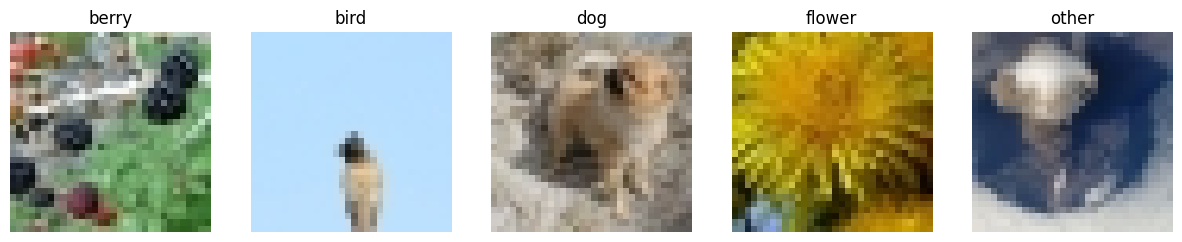

In [107]:
def rescale(img):
    return (img + 1) / 2

fig, axs = plt.subplots(1, len(trainset.classes), figsize=(15, 3))
for i in range(len(trainset.classes)):
    cls = trainset.classes[i]
    axs[i].imshow(rescale(to_display[cls].numpy()).transpose(1, 2, 0))
    axs[i].axis('off')
    axs[i].set_title(cls)
plt.show()

### Question 2 [0.5 point]

```
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
)]
```
The above transform has two stages.
1. Take an input image (either a PIL image or numpy array of shape (H, W, C)) and converts it into a torch tensor of shape (C, H, W) whilst scaling from [0, 255] to [0, 1]. 
2. normalise transform applies channel-wise normalisation for each pixel. It computes $x_{norm} = \frac{x-0.5}{0.5}$. This transforms the pixel ranges from [0, 1] to [-1, 1].


***
### Question 3 [1 point]

In [8]:
class myCNN(nn.Module):
    def __init__(self):
        super(myCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.mp1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.mp2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.mp3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(in_features=4096, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=64)
        self.fc3 = nn.Linear(in_features=64, out_features=5)

        self.relu = nn.ReLU()

    def forward(self, x, get_features=False):
        # cnn
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.mp1(x)
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.mp2(x)
        x = self.relu(self.conv5(x))
        x = self.relu(self.conv6(x))
        x = self.mp3(x)

        if get_features:
            return x

        # flatten
        x = x.view(-1, 4096)

        # fcn
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)

        return x

***
### Question 4 [0.5 point]

In [9]:
torchsummary.summary(myCNN().cuda(), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          18,496
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14            [-1, 25

***
### Question 5 [0.5 point]

In [10]:
def train(myCNN, nr_epochs, optimizer ,criterion, trainloader):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion.to(device)


    for epoch in range(nr_epochs):
        for inputs, labels in trainloader:
            optimizer.zero_grad()

            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = myCNN(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

            nputs = inputs.cpu()
            labels = labels.cpu()

            optimizer.step()


        if epoch % 1 == 0:
            print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch, nr_epochs, loss.item()))

    model.cpu()
    criterion.cpu()

***
### Question 6 [0.5 point]

In [8]:
model = myCNN()

n_epochs = 30
optim = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train(model, n_epochs, optim, criterion, trainloader)

Epoch [0/30], Loss: 1.4070
Epoch [1/30], Loss: 1.2738
Epoch [2/30], Loss: 1.3283
Epoch [3/30], Loss: 1.2450
Epoch [4/30], Loss: 1.2149
Epoch [5/30], Loss: 1.2816
Epoch [6/30], Loss: 1.1733
Epoch [7/30], Loss: 1.1108
Epoch [8/30], Loss: 1.0217
Epoch [9/30], Loss: 0.7597
Epoch [10/30], Loss: 0.9319
Epoch [11/30], Loss: 0.6584
Epoch [12/30], Loss: 0.5902
Epoch [13/30], Loss: 0.6845
Epoch [14/30], Loss: 0.5496
Epoch [15/30], Loss: 0.6232
Epoch [16/30], Loss: 0.3814
Epoch [17/30], Loss: 0.3613
Epoch [18/30], Loss: 0.3442
Epoch [19/30], Loss: 0.1980
Epoch [20/30], Loss: 0.2919
Epoch [21/30], Loss: 0.2655
Epoch [22/30], Loss: 0.1310
Epoch [23/30], Loss: 0.1670
Epoch [24/30], Loss: 0.0793
Epoch [25/30], Loss: 0.0897
Epoch [26/30], Loss: 0.1540
Epoch [27/30], Loss: 0.0734
Epoch [28/30], Loss: 0.1289
Epoch [29/30], Loss: 0.0534


In [ ]:
torch.save(model.state_dict(), 'mycnn.pth')

***
### Question 7 [0.5 point]

In [12]:
def accuracy(model, testloader):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    correct = {n: 0 for n in range(5)}
    total = {n: 0 for n in range(5)}
    model.to(device).eval()

    with torch.no_grad():
        for inputs, labels in testloader:
            output = model(inputs.to(device))
            output_argmax = torch.argmax(output, dim=-1).cpu()
    
            for u in torch.unique(labels):
                idxs = labels == output_argmax
                correct_for_class = torch.sum(labels[idxs] == output_argmax[idxs]).item()
                correct[u.item()] += correct_for_class
                total[u.item()] += labels.shape[0]

    c = testloader.dataset.class_to_idx
    for class_name in testloader.dataset.classes :
        print (f" Accuracy for class ’{class_name}’: {correct[c[class_name]] / total[c[class_name]] * 100:.2f}% ")

cnn = myCNN()
cnn.load_state_dict(torch.load('mycnn.pth', weights_only=True))
cnn.eval()

accuracy(cnn, testloader)

 Accuracy for class ’berry’: 73.44% 
 Accuracy for class ’bird’: 60.94% 
 Accuracy for class ’dog’: 77.73% 
 Accuracy for class ’flower’: 72.07% 
 Accuracy for class ’other’: 67.03% 


***
## Part 2: Fine-tuning a pretrained model [3.5 points]

### Question 1 [0.5 point]

In [14]:
transform_small = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size_small = 128

# trainset_small = torchvision.datasets.ImageFolder(root="Linnaeus_5_32X32_small\\train", transform=transform)
trainset_small = torchvision.datasets.ImageFolder(root="Linnaeus_5_32X32_small/train", transform=transform_small)

trainloader_small = torch.utils.data.DataLoader(trainset_small, batch_size=batch_size_small, shuffle=True)

# testset_small = torchvision.datasets.ImageFolder(root="Linnaeus_5_32X32_small\\test", transform=transform)
testset_small = torchvision.datasets.ImageFolder(root="Linnaeus_5_32X32_small/test", transform=transform_small)

testloader_small = torch.utils.data.DataLoader(testset_small, batch_size=batch_size_small, shuffle=False,)

***
### Question 2 [1 point]

LogSoftmax: Converts the raw logits (i.e. the unbounded output of the final linear layer) into log probabilities. This step is critical because:

It ensures numerical stability.
It provides inputs in the form that NLLLoss expects.

In [16]:
class myMLP(nn.Module):
    def __init__(self):
        super(myMLP, self).__init__()
        self.fc1 = nn.Linear(4096, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 2)
        
        self.relu = nn.ReLU()
        
        self.act = nn.LogSoftmax(dim=-1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        
        x = self.act(x)
        return x

#### 1. Determine and justify the number of input nodes for the MLP.

We are using the MLP to process the extracted features from the CNN. This is taken as the output from the convolutional and maxpool layers. Therefore the input of the MLP must match a flattened output from the CNN's feature extraction layers. With a 32x32 image input, the CNN's mp3 layer outputs a tensor of shape 4x4 with 256 channels. 4\*4\*256 = 4096. Therefore we need 4096 input nodes in the MLP. 

#### 2. We are going to use the negative log likelihood loss for training later, with criterion torch.nn.NLLLoss(). Based on the lecture notes and the PyTorch documentation, find and explain what nonlinear function should we use at the output layer of the MLP. Also explain why this loss function is an appropriate choice for this task.

Based on the use of NLLLoss, it is logical to use LogSoftmax as our nonlinear function. The pytorch documentation for NLLLoss indicate that it expects log probabilities to compute the negative log likelihood. LogSoftmax converts the raw logits into their log probabilities which is exactly as required. The combination of NLLLoss and LogSoftmax benefits from better numerical stability compared to alternatives such as just Softmax. Numerically it is also equivalent to using CrossEntropyLoss which uses LogSoftmax internally. 

In [15]:
torchsummary.summary(myMLP().cuda(), input_size=(4096,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]         524,416
              ReLU-2                  [-1, 128]               0
            Linear-3                  [-1, 128]          16,512
              ReLU-4                  [-1, 128]               0
            Linear-5                    [-1, 2]             258
        LogSoftmax-6                    [-1, 2]               0
Total params: 541,186
Trainable params: 541,186
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 0.00
Params size (MB): 2.06
Estimated Total Size (MB): 2.08
----------------------------------------------------------------


***
### Question 3 [0.5 point]

In [18]:
def fine_tune(myCNN, myMLP, nr_epochs, optimizer, criterion, trainloader):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    myMLP.to(device)
    myCNN.to(device)
    batch_size = trainloader.batch_size
    
    criterion.to(device)

    # freeze cnn
    for param in myCNN.parameters():
        param.requires_grad = False

    for epoch in range(nr_epochs):
        for inputs, labels in trainloader:
            optimizer.zero_grad()

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            features = myCNN.forward(inputs, get_features=True)
            features = features.view(features.shape[0], -1)
            outputs = myMLP(features)
            
            loss = criterion(outputs, labels)
            loss.backward()

            inputs = inputs.cpu()
            labels = labels.cpu()

            optimizer.step()


        if epoch % 1 == 0:
            print('Epoch [{}/{}], Loss: {:.8f}'.format(epoch, nr_epochs, loss.item()))

    myMLP.cpu()
    myCNN.cpu()
    criterion.cpu()

***
### Question 4 [0.5 point]

In [23]:
cnn = myCNN()
cnn.load_state_dict(torch.load('mycnn.pth', weights_only=True))
cnn.eval()

mlp = myMLP()

n_epochs = 30
optim = torch.optim.Adam(mlp.parameters(), lr=0.001)
criterion = nn.NLLLoss()

fine_tune(cnn, mlp, n_epochs, optim, criterion, trainloader_small)

Epoch [0/30], Loss: 0.03034190
Epoch [1/30], Loss: 0.02114680
Epoch [2/30], Loss: 0.00308281
Epoch [3/30], Loss: 0.00037422
Epoch [4/30], Loss: 0.00055709
Epoch [5/30], Loss: 0.00195786
Epoch [6/30], Loss: 0.00006142
Epoch [7/30], Loss: 0.00015321
Epoch [8/30], Loss: 0.00008415
Epoch [9/30], Loss: 0.00004754
Epoch [10/30], Loss: 0.00004157
Epoch [11/30], Loss: 0.00002248
Epoch [12/30], Loss: 0.00000315
Epoch [13/30], Loss: 0.00056532
Epoch [14/30], Loss: 0.00004048
Epoch [15/30], Loss: 0.00006879
Epoch [16/30], Loss: 0.00001287
Epoch [17/30], Loss: 0.00016789
Epoch [18/30], Loss: 0.00000719
Epoch [19/30], Loss: 0.00000754
Epoch [20/30], Loss: 0.00000537
Epoch [21/30], Loss: 0.00000111
Epoch [22/30], Loss: 0.00002647
Epoch [23/30], Loss: 0.00000132
Epoch [24/30], Loss: 0.00000468
Epoch [25/30], Loss: 0.00001248
Epoch [26/30], Loss: 0.00006904
Epoch [27/30], Loss: 0.00001489
Epoch [28/30], Loss: 0.00000493
Epoch [29/30], Loss: 0.00003881


In [24]:
torch.save(mlp.state_dict(), 'mymlp.pth')

***
### Question 5 [1 point]

In [20]:
def accuracy_fine_tune(myCNN, myMLP, testloader_small):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    myMLP.to(device).eval()
    myCNN.to(device).eval()
    batch_size = trainloader_small.batch_size
    
    correct = {n: 0 for n in range(5)}
    total = {n: 0 for n in range(5)}

    with torch.no_grad():
        for inputs, labels in testloader_small:
            features = myCNN.forward(inputs.to(device), get_features=True)
            features = features.view(features.shape[0], -1)
            outputs = torch.exp(myMLP(features))
            output_argmax = torch.argmax(outputs, dim=-1).cpu()
    
            for u in torch.unique(labels):
                idxs = labels == output_argmax
                correct_for_class = torch.sum(labels[idxs] == output_argmax[idxs]).item()
                correct[u.item()] += correct_for_class
                total[u.item()] += labels.shape[0]

    c = testloader_small.dataset.class_to_idx
    # Print the accuracy for each class
    for class_name in testloader_small.dataset.classes :
        print (f" Accuracy for class ’{class_name}’: {correct[c[class_name]] / total[c[class_name]] * 100:.2f}%")

mlp = myMLP()
mlp.load_state_dict(torch.load('mymlp.pth', weights_only=True))
mlp.eval()

accuracy_fine_tune(cnn, mlp, testloader_small)

 Accuracy for class ’dog’: 95.51%
 Accuracy for class ’flower’: 96.88%


#### Comment on the results and compare the accuracy of the fine-tuned model with the accuracy of the CNN model from Part 1.

- The CNN achieved class accuracies ranging from 61% to 78%. In contrast, the fine tuned model with the MLP reached above 95% accuracy on both classes it was trained on.

- This is not a surprising result as we reduced the complexity of the task my removing 3 of 5 categories, reducing the problem to only a binary classification. This makes it inherently easier for the model to distinguish between the two remaining classes due to simpler decision boundaries. 

- The original model's fully connected layers were tasked with identifying 5 different classes. By adding more 'post-processing' parameters in the form of the MLP to classify from extracted features, thereby giving the model more capacity to learn and resulting in high accuracies.

- It is evident that the CNN on its own struggled to generalise well on its more challenging dataset. The greatly improved accuracies with the fine tuning indicate that the feed forward layers of the CNN were inadequate for the scale of the original task. On the other hand, the feature extraction layers of the CNN were useful in the fine tuning and show that they learnt well.

- Training the CNN's feature extraction layers on a broader dataset was probably beneficial as it was exposed to a richer set of features, shapes and objects, therefore feeding the fine-tuned MLP better extracted features than if the CNN was only trained on the two dog and flower classes.

- The CNN started at a high loss and steadily decreased over the epochs, showing some variability with occasional increases and decreases. This reflects the complexity of it's original task and show how the feed forward layers int the original model were struggling. In contrast, the loss for the fine tuned MLP drops rapidly to near 0, indicating that the binary classification problem was learned very quickly, meaning a larger feed forward classifier was easily able to capture the differences between only two classes.

- We might have has concerns about overfitting given the training loss of the MLP being near zero, however the test accuracies show us that this the model generalised well.

***
## Part 3: Adversarial attacks [4.5 points]

***
### Question 1 [1 point]

In [109]:
def adversarial(myCNN, myMLP, image, label, epsilon=0.01):
    # Select device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Move models to device
    myCNN.to(device)
    myMLP.to(device)

    # Make a clone of the image and move it to device
    image = image.clone().to(device)

    # Set models to evaluation mode
    myCNN.eval()
    myMLP.eval()

    # NLLLoss matches your MLP's LogSoftmax output
    criterion = nn.NLLLoss()

    nr_steps = 10
    mu = 1.0
    alpha = epsilon / nr_steps

    # Momentum term (same shape as image, on device)
    g = torch.zeros_like(image, device=device)

    # The input that will be perturbed (enable gradient tracking)
    x = image.detach().requires_grad_()
    x.to(device)

    # Label tensor on the device
    # lbl = torch.tensor(label, device=device).unsqueeze(0).long()
    lbl = torch.as_tensor(label, device=device).unsqueeze(0).long().to(device)

    for i in range(nr_steps):
        # Zero the model gradients
        myCNN.zero_grad()
        myMLP.zero_grad()

        # Forward pass
        output = myCNN(x.unsqueeze(0), get_features=True)
        output = output.view(output.size(0), -1)
        output = myMLP(output)  # Already log probabilities

        # Compute loss
        loss = criterion(output, lbl)

        # Backprop to get gradient w.r.t. x
        loss.backward()
        grad = x.grad

        # Update momentum term (with L1-norm normalization)
        grad_norm = torch.norm(grad, p=1) + 1e-8  # small eps to avoid div-by-zero
        g = mu * g + grad / grad_norm

        # FGSM-like step with sign of momentum
        x = x + alpha * torch.sign(g)

        # Detach and require grad for next iteration
        x = x.detach().requires_grad_()

    # Final adversarial image
    adv_image = x.detach()

    # Optionally move back to CPU for further processing
    adv_image_cpu = adv_image.cpu()

    # Evaluate the final probability for the true label
    output = myCNN(adv_image.unsqueeze(0), get_features=True)
    output = output.view(output.size(0), -1)
    output = myMLP(output)  # log probabilities
    p = torch.exp(output)[0, label].item()

    return adv_image_cpu, p


### Question 2 [1 point]

#### Explain the role of the parameter epsilon in the function and how the algorithm is working.

Epsilon ($\epsilon$) is the 'size of the perturbation'. Intuitively it defines a search space around x, the maximum allowed change under the $L_\infty$ norm, in which to find an adversarial example. The idea is that within this small $\epsilon$-radius of our starting image, we can find a similar adversarial image which gives us a different output from the classifier and this adversarial example is at most '$\epsilon$ far' from the original image. Higher epsilons have higher success rates in finding an adversarial example but at the cost of imperceptibility (i.e. the adverse example will be more different to the original).

The algorithm starts by initialising the following variables. $\alpha = \frac{\epsilon}{T}$, where T is the number of iterations, is set as a step size such that even if we travel in the same direction T times, we are at most $\epsilon$ from the starting image and ensuring we stay within the $\epsilon-L_\infty$ ball. $g_0=0$ initialises our momentum variable to 0. And $x^*_0=x$ begins our search for the adversarial image at the original image.

The algorithm loops for $0 \leq t \leq T-1$:
- In each iteration it classifies the current image $x^*_t$ and computes the gradient of the loss function (in our case NLLLoss) with respect to $x^*_t$.
- This gradient ($grad$) is then used to update the momentum variable as follows: $g_{t+1} = \mu \cdot g_t + \frac{grad}{\| grad \|_1}$. The previous momentum is multiplied by a decay variable $\mu$ and the newest normalised gradient is added. The decay variable determines how strongly the momentum rememberes gradients from far in the past. By building this momentum, the algorithm can better navigate the loss landscape, i.e. noisy or oscillating gradients, in search of the adversarial example.
- Then the sign of the momentum $g_{t+1}$ is used to update the current image as follows: $x^*_{t+1} = x^*_t + \alpha \cdot \text{sign}(g_{t+1})$. The effect of the momentum can be understood with a simple example, e.g. if there is lots of initial momentum in the positive direction and then a small amount in the negative direction, we can see how the momentum would likely still have positive sign. Therefore the algorithm would not react to the small negative gradient and continue the search in the positive direction.

After T iterations, the current image is taken as the adversarial image.

***
### Question 3 [0.5 point]

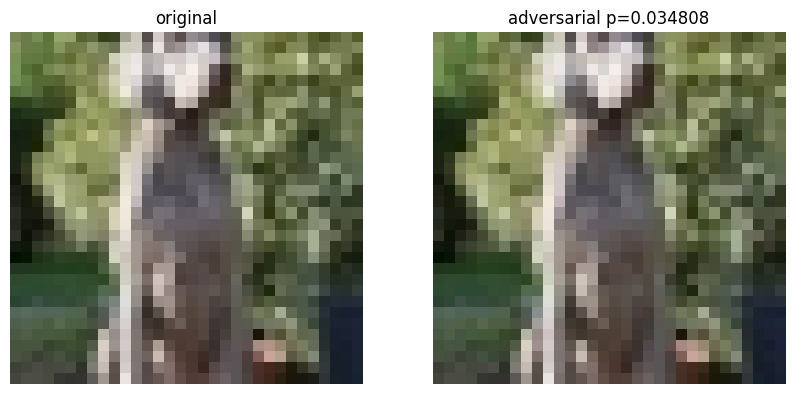

In [101]:
def rescale(img):
    return (img + 1) / 2

im, l = testset_small[5]
adv, p = adversarial(cnn, mlp, im, l)

diff = (adv - im)

im_ = rescale(im).detach().numpy().transpose(1, 2, 0)
adv_ = rescale(adv).detach().numpy().transpose(1, 2, 0)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(im_)
ax[1].imshow(adv_)
ax[0].set_title("original")
ax[1].set_title(f"adversarial p={p:.6f}")
ax[0].axis('off')
ax[1].axis('off')
plt.show()

***
### Question 4 [0.5 point]

In [111]:
def accuracy_adversarial(myCNN, myMLP, testloader_small, epsilon):
    total_correct = 0
    total_attacked = 0

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    myCNN = myCNN.to(device)
    myMLP = myMLP.to(device)

    # iterate over all batches of the test images
    for data in testloader_small:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        # Evaluate the fine-tuned model
        outputs = myCNN.forward(images, get_features=True)
        outputs = outputs.view(outputs.shape[0], -1)
        outputs = torch.exp(myMLP(outputs))
        output_argmax = torch.argmax(outputs, dim=-1)
        correct = (output_argmax == labels)

        # Loop over the images classified correctly in the current batch
        for im, lbl in zip(images[correct], labels[correct]):

            total_correct += 1
            # Generate an adversarial example
            adv, p = adversarial(myCNN, myMLP, im, lbl, epsilon)
            # Check if the attack was successful
            if p < 0.5:
                total_attacked += 1

    return total_attacked / total_correct
accuracy_adversarial(cnn, mlp, testloader_small, 0.05)

0.6532467532467533

***
### Question 5 [1 point]

In [114]:
es = [0.02, 0.04, 0.06, 0.08, 0.1]
adv_success_rates = [accuracy_adversarial(cnn, mlp, testloader_small, e) for e in es]

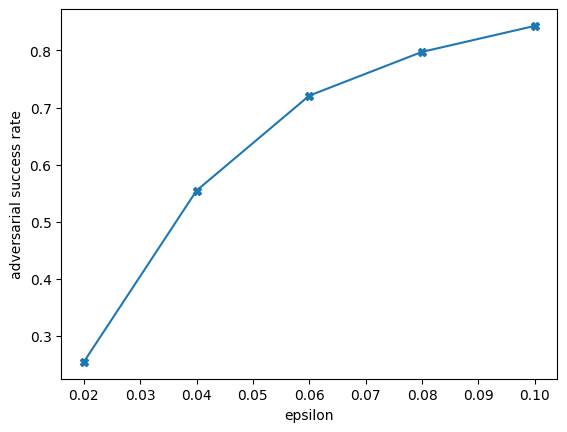

[(0.02, 0.2545454545454545),
 (0.04, 0.5545454545454546),
 (0.06, 0.7207792207792207),
 (0.08, 0.7974025974025974),
 (0.1, 0.8428571428571429)]

In [115]:
plt.plot(es, adv_success_rates, marker='X')

plt.xlabel('epsilon')
plt.ylabel('adversarial success rate')

plt.show()
list(zip(es, adv_success_rates))

#### comment on results

The trend is that the success rate of finding an adversarial image grows with $\epsilon$. From $\epsilon=0.02$ to $0.06$, there is quite a sharp increase from 25% to 72%, after which it plateaus to 84% at $\epsilon=0.1$.

This outcome is expected. As explained in the description of the algorithm, $\epsilon$ defines the $L_\infty$ ball around the original image (pixel-wise) in which we can search for an adversarial example. Higher epsilon will naturally result in higher success rate due to the fact we have a wider search radius and we can stray further from the original in search of an image that the classifier thinks is different. However, if we compared successful examples at $\epsilon=1$ and $\epsilon=0.05$ to the original, the $\epsilon=0.05$ example would likely be more similar and be considered a better adversarial example as it was able to fool the classifier with less changes to the input.

The rapid increase at smaller epsilons indicate that the model is robust at these small epsilons but quickly becomes vulnerable to attack as epsilon grows. The plateauing curve shows diminishing returns past $\epsilon=0.1$.

***
### Question 6 [0.5 point]

#### Comment on the impact of adversarial attacks in real-world applications and discuss possible ways to mitigate them. (Machine learning researchers are usually required to include a broader impact statement in their papers about potential consequences of their work, which is why I’m including this question)

Adversarial attacks can have an impact anywhere that machine learning models are deployed in the real world, especially in security and privacy sentitive settings. E.g.: 
- Autonomous vehicles may not decide to brake at the sight due to the mis-classification of a human or obstacle on the road in the object detection software.
- Medical diagnosis software used to scan MRIs and X-rays. A segmentation model can fail to identify a tumor or hairline fracture in an image and thereby resulting in a critital mis-diagnosis of the patient.
- Biometric authentication systems must be absolutely robust to small perturbations in input fingerprint/facial scan so as to not allow for unauthorised access.

Each of the above examples could have widespread and detremental impact if the adversarial attacks are not properly accounted for in the deployment of these ml models. Therefore it is essential that these developers investivate the robustness of their models.

There are many ways of mitigating these adversarial attacks: E.g.:
- Training/tuning models on adversarially collected images. This method allows the model to learn from its mistakes and define better decision boundaries between classes, becoming more robust against small perturbations in its input. This method might take time and effort to collect enough examples and then fine tune the model.
- Training with augmentation e.g. cropping, resizing, adding small amounts of noise, random colour scale adjustments. Used in the appropriate setting for images, e.g. our example above would have worked, augmentations work as a regularisation and makes the model more robust to small insignificant changes that it might have otherwise been fooled by. This method has close to no additional cost at training time and none at evaluation time. 
- Ensemble models. This method runs multiple trained versions of the model, usually in parallel, and combines them to create an output. E.g. out of 5 models, 4 classify the image as class 3 and 1 classifies as class 2, the overall vote would lean in favour of class 4. We can easily see how this would make it harder for adversarial examples to fool more than one model. You could also use ensemble models to run confidence checks and evaluating statistical significance of outcomes. However this comes at a large cost of not only storing but also running computation on all of these unique models.
- Monte-carlo dropout model. Models can be designed with dropout layers. Inference on the input can be run multiple times, each time giving the dropout layers a chance to regularise the model differently. We can therefore use this one model in the same way as the ensemble models described previously.